## Let's build VGG
Great so we have our train/test data converted into a dataset object then loaded into a DataLoader! This means we are ready to jump into building the network that will train and evaluate on these images.

### Very Deep CNNs for Large Scale Image Recognition

To build our network we will be relying on a model architecture explored in this paper:
[VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION](https://arxiv.org/pdf/1409.1556.pdf)

This model was designed to predict 1000 different class labels. This is much larger than the task the we have at hand. For us, we just need to classify 3 different types of images: artwork, detail, and install.

Hopefully this will make our task easier! Will our task need less network parameters to achieve equal performance? We shall see. This stage will require a lot of testing, tweeking, and evaluating. Hopefully I'm up for the task. Let's roll.

#### Notes From The Paper
This paper begins by noting that increasing the CNN depth to 16-19 weight layers provides significant improvement to image classificier networks.

The prefice there work by talking about advancements made to ConvNets by using smaller receptive window sizes and smaller stride of the first conv layer, as well as, training and testing over the whole image and over multiple scales. In this paper the network density will be examined.

They begin with an RGB image of size 224x224 with the mean RGB value subtracted from each pixel. The idea of doing this is that it will center the pixel values around zero and it would allow for easier normalization of the input data if that is desired. This technique may lead to faster convergence, reduced sensitivity, and improved generalization (this is my interpretation).

This input is placed through a 3x3 Conv2d filters, in one instance a 1x1 Conv2d filter is applied - this can be viewed as a linear transformation which is then followed by some type of nonlinear activation function. The stride is fixed to 1 pixel for these Conv filters and the padding for the 3x3 is fixed to 1. Spatial pooling is carried out by 5 max pooling layers, these max pool layers are performed over a 2x2 window with a stride of 2. All hidden layers are equipped with the ReLU activation function for non-linearity. The paper refers to the use of Local Response Normalisation (which was used for one model tested), they did not find that it improved performance. For our scenario we will not use LRN.

The authors address the advantages of using consecutive conv2d filters between each downsampling maxpool layers. The address an arguement that the receptive field of the convlution is effectively 7x7, so why not just use one conv2d filter with that size of a receptive field. They argue that not only does using stacked, smaller kernel windows, leads to less trainable parameters, they also place ReLU activation functions between each step, adding increased non-linearity to capture capture more features.

After describing the architecture of their network the move to the classification framework. During training they optimise the multinomial logistic regression objective by using mini-batch gradient descent with momentum. Batch size was set to 256 and momentum to 0.9. For our purposes we will use a much smaller batchsize - 32 or 16 - and we will maintain the same momentum at first, but attempt several iterations with different optimizers (perhaps Adam) and different momentum values to attempt to find minimum loss.

The authors speak about the necessity for proper intialisation of the network weights. Bad inti can stall learning due to isntability of gradients in deep nets. They used a process where they took the architecture from network A, trained it then transfered the weight values to the deep networks. We'll have to see how our classifier works, we might not need to worry about proper intialization.... I don't know. The data set was cropped and training dataset had random horizontal flipping and random RGB color shift. For our case, we do not want to track RGB features, so we will grayscale our images and only pass in one color channel. This should speed up train and eval times!

More details are outlined about training parameters and methodology. We will likely have to refer to this as we build our training loop. But it's really all straight forward stuff outlineing how the data was handled. They then talk about how they implmented this in C++, obviously we are using PyTorch, so...

The dataset they worked with was very large, around 1.5M images in total. Our dataset incredibly tiny. Hopefully that wont bite us in the butt! I think we will have luck since we are only trying to predict 3 different classes. 

In [143]:
import torch
from torch import nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [45]:
# Let's take a look at our dataset real quick
# We'll see how our img/ directory is structure and how many images are in each
from pathlib import Path
import os

def walk_through_dir(dir_path):
    """Walks through dir_path returning its contenst"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")

image_path = Path("./img/")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'img
There are 3 directories and 0 images in 'img/train
There are 0 directories and 826 images in 'img/train/detail
There are 0 directories and 826 images in 'img/train/install
There are 0 directories and 831 images in 'img/train/artwork
There are 3 directories and 0 images in 'img/test
There are 0 directories and 130 images in 'img/test/detail
There are 0 directories and 200 images in 'img/test/install
There are 0 directories and 200 images in 'img/test/artwork


Random image path: img/train/install/c882.jpg
Random image class: install
Random image height: 2398
Random image width: 1600


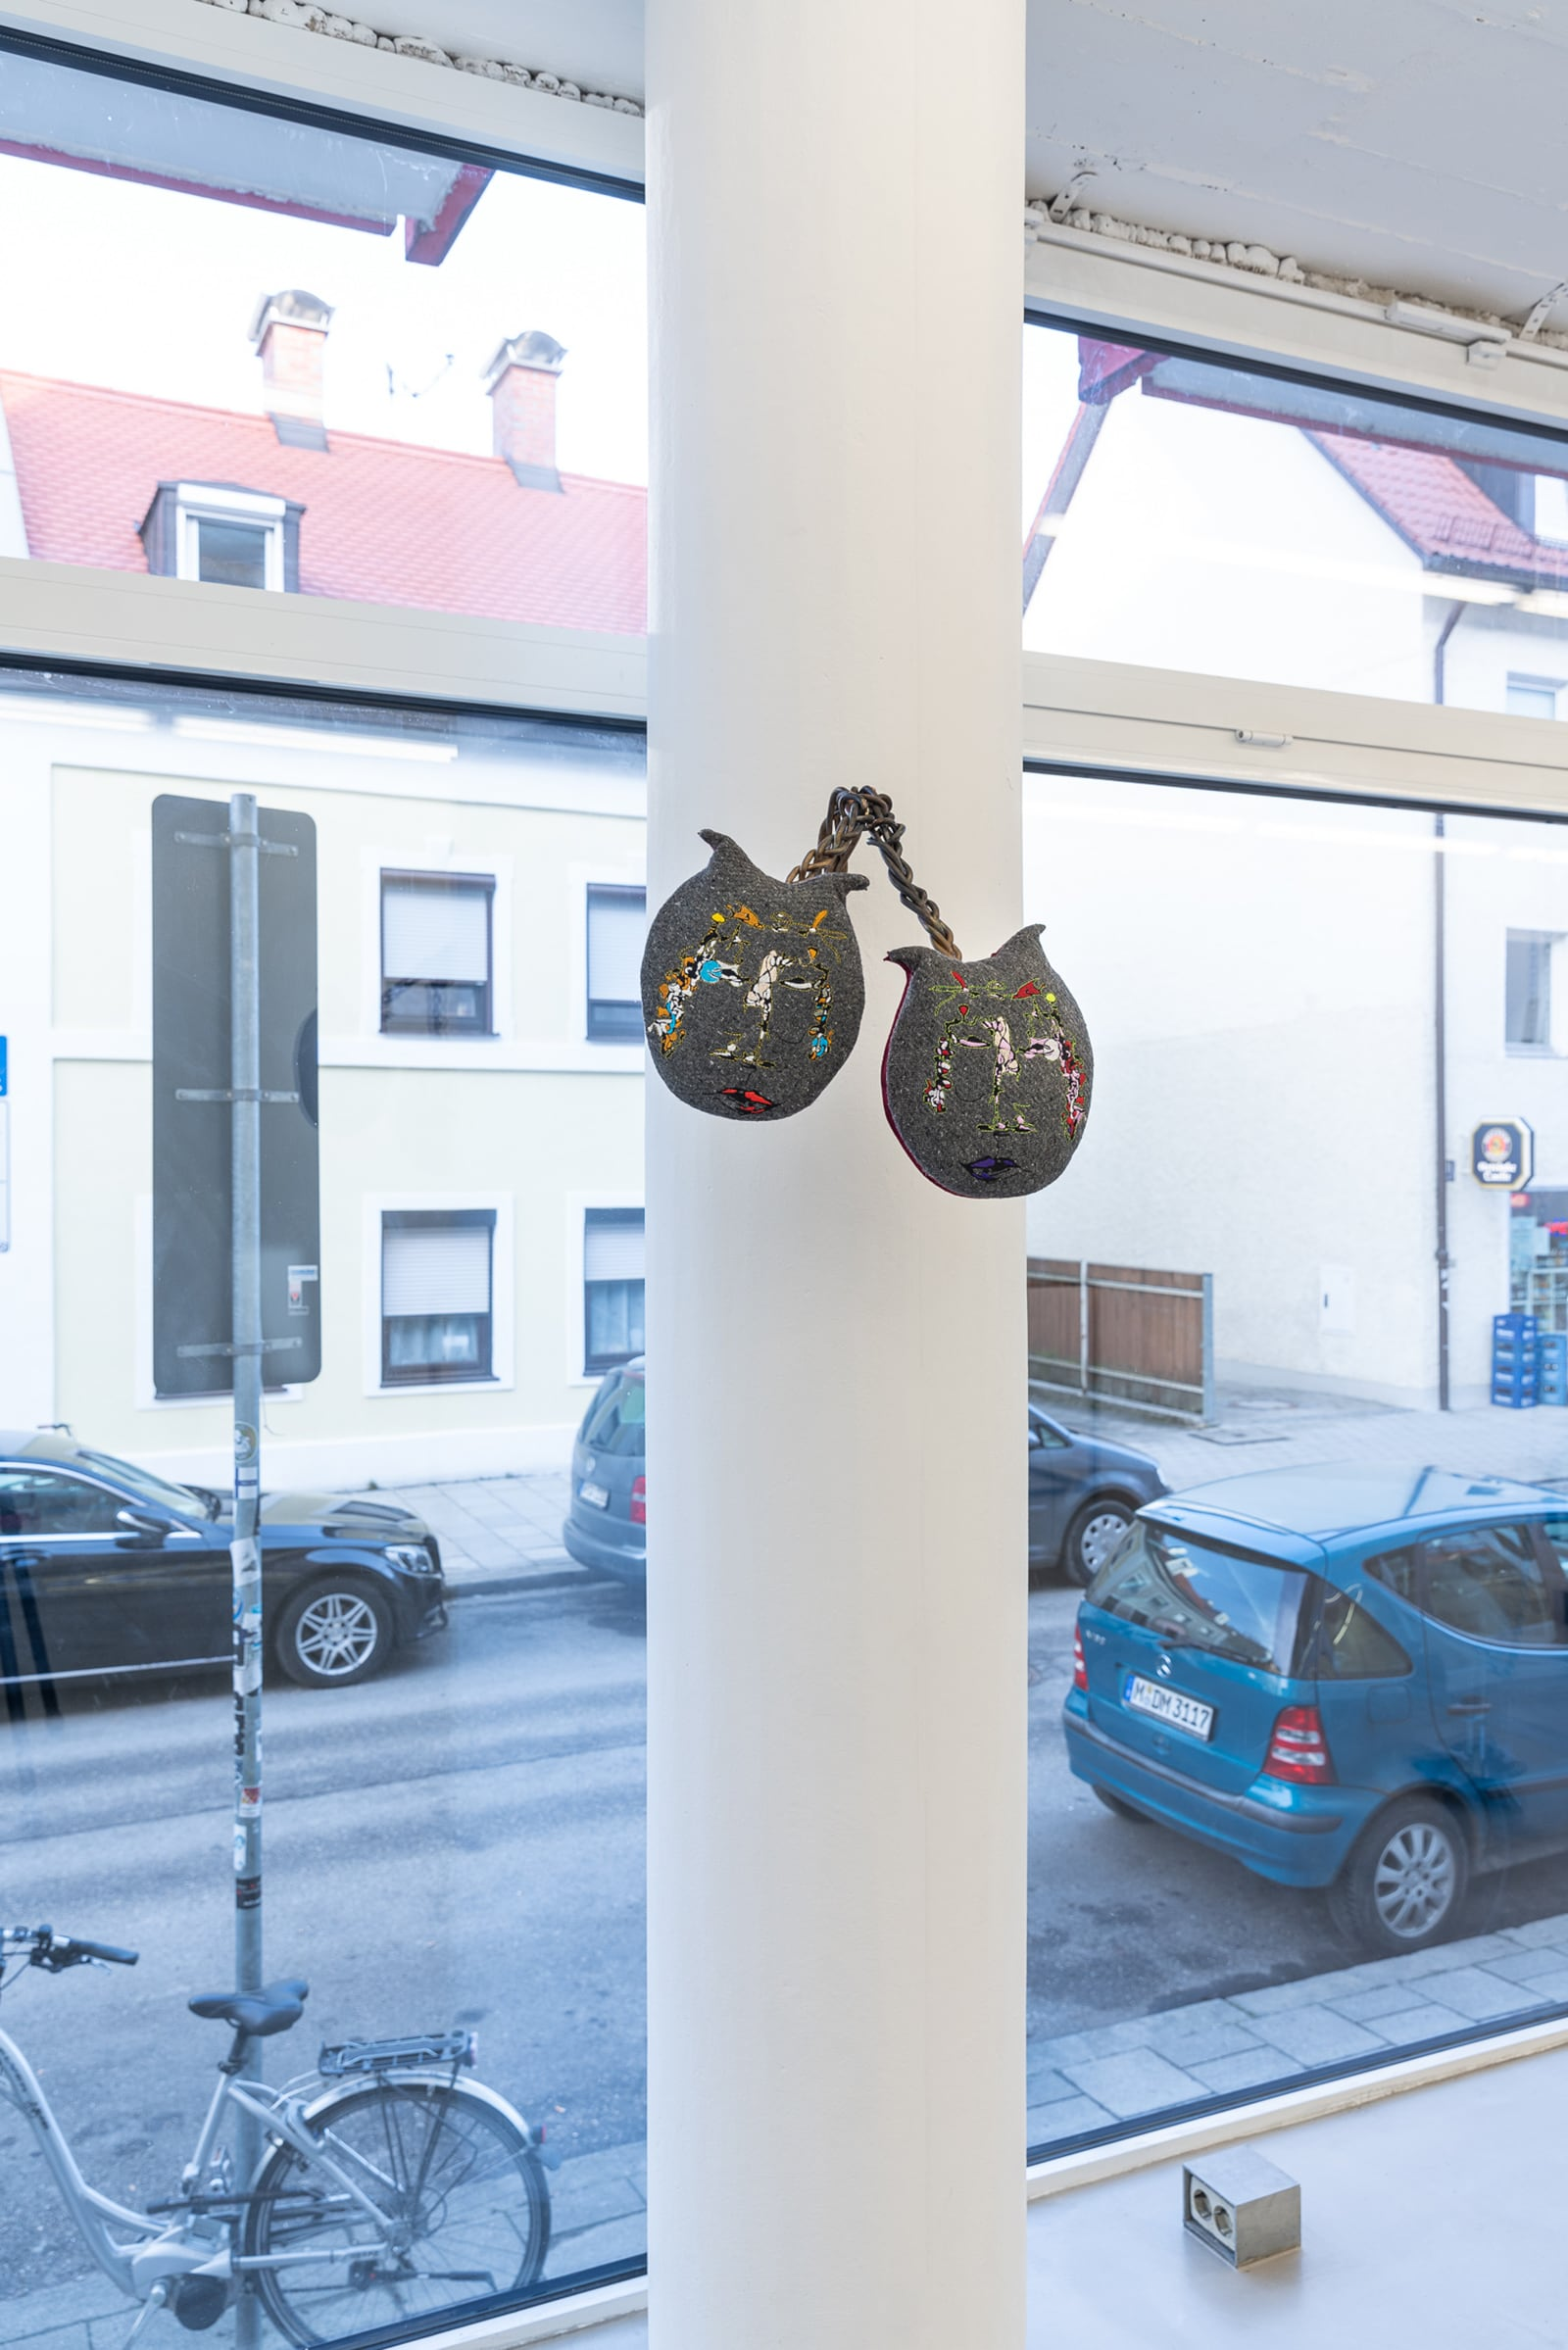

In [144]:
import random
from PIL import Image

#random.seed(2697)

# Set up train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"



# Display a random image
image_path_list = list(image_path.glob("*/*/*.jpg"))
rand_image_path = random.choice(image_path_list)

image_class = rand_image_path.parent.stem

img = Image.open(rand_image_path)
print(f"Random image path: {rand_image_path}")
print(f"Random image class: {image_class}")
print(f"Random image height: {img.height}")
print(f"Random image width: {img.width}")
img

torch.Size([224, 224, 1])


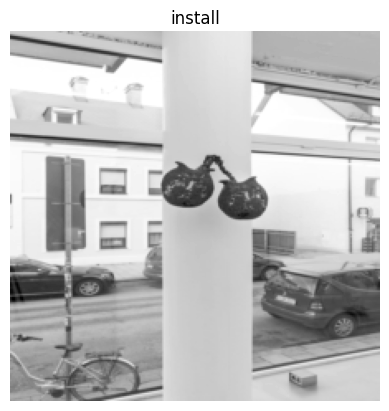

In [145]:
# Let's create a transform for our data to try to regularize it
# We will need to resize, do some random flipping, and cast it to a tensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# We are choosing 512x512 now, this might need to be scaled depending on GPU demands
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

tensor_img = train_transform(img)
tensor_img_permute = tensor_img.permute(1,2,0)
print(tensor_img_permute.shape)
plt.title(image_class)
plt.axis("off")
plt.imshow(tensor_img_permute, cmap="gray");


In [146]:
# Load data to a custom dataset - ImageFolder style

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                  transform=test_transform,
                                  target_transform=None)

class_names = train_data.classes
class_names

['artwork', 'detail', 'install']

In [147]:
# Turn this into a DataLoader

BS = 32

train_dl = DataLoader(dataset=train_data,
                      batch_size=BS,
                      num_workers=os.cpu_count(),
                      shuffle=True)
test_dl = DataLoader(dataset=test_data,
                      batch_size=BS,
                      num_workers=os.cpu_count(),
                      shuffle=True)

In [148]:
#img, label = next(iter(train_dl))

#print(f"Image Shape: {img.shape} -> [batch_size, color_channels, height, width]")
#print(f"Label Shape: {label.shape}")
#label[0]

In [141]:
# Time to construct the first iteration of the CNN
# After some thought I'm going to us the VGG version B network architecture to start

# Start by building a double conv-maxpool block 
class DoubleConv(nn.Module):
    def __init__(self, in_channels, hidden_features, out_channels):
        super().__init__()
        self.doubleconv =


/bin/bash: line 1: hp: command not found
